<a href="https://www.kaggle.com/code/angelchaudhary/sales-forecasting-for-a-retail-chain?scriptVersionId=292955383" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A Comparative Study of Predicting Retail Sales Using Time Series Analysis and Machine Learning

# Introduction

Retail businesses must strike a balance between meeting customer demand and managing inventory efficiently. Poor sales forecasting can lead to:

- **Overstocking**, increasing storage and holding costs  
- **Stockouts**, resulting in lost revenue and dissatisfied customers  

The objective of this case study is to **predict future sales for a retail chain using historical sales data**, enabling better inventory planning and demand forecasting. We'll focus on **monthly or weekly sales forecasting**, capturing both **seasonal patterns** and **long-term trends** in the data.

Sales forecasting is one of the most practical and widely used applications of data science in real businesses.  
This Case Study:
- addresses a **real-world retail problem**, not a synthetic prediction task  
- emphasizes **seasonality and trend analysis**, which are critical in retail  
- compares **classical statistical models (ARIMA)** with **machine learning approaches**  
- evaluates models from a **business decision-making perspective**, not just accuracy  

Rather than relying on a single model, this study demonstrates how to **compare forecasting approaches and select the most reliable one** for production use.

## Approach

This project follows a structured forecasting workflow:

1. **Exploratory Time Series Analysis**
   - Visualize historical sales trends
   - Identify seasonality, trends, and anomalies
   - Decompose the time series into trend, seasonal, and residual components

2. **Feature Engineering**
   - Create time-based features (month, week, year)
   - Generate lag features and rolling statistics
   - Prepare the dataset for machine learning models

3. **Modeling**
   - Build a baseline **ARIMA** model for statistical forecasting
   - Train **machine learning models** using engineered features
   - Maintain consistent train–test splits for fair comparison

4. **Model Evaluation & Comparison**
   - Compare ARIMA and ML models using forecasting metrics
   - Analyze strengths and limitations of each approach
   - Identify the model best suited for retail demand forecasting

5. **Business Interpretation**
   - Translate predictions into inventory planning insights
   - Discuss how forecasting reduces overstocking and stockouts
   - Outline limitations and future improvements

# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExYmVkYjF6eHcxMXIxcnh6d2NkaHRyeXRlY2oxdXczN3o2dWRkeW9hZSZlcD12MV9naWZzX3NlYXJjaCZjdD1n/5r5J4JD9miis/giphy.gif)

## Dataset Overview
This dataset contains historical weekly sales data for multiple Walmart stores along with economic and seasonal indicators. For this study, sales are aggregated at the retail chain level to model overall demand patterns and forecast future sales.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rutuspatel/walmart-dataset-retail")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/walmart-dataset-retail


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/walmart-dataset-retail/Walmart_Store_sales.csv")
df.head(2)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106


In [6]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [7]:
# Dataset shape
df.shape

(6435, 8)

In [8]:
# Data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


### Date Conversion & Time Indexing

In [10]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
# Sort by date
df = df.sort_values('Date')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
429,4,2010-02-05,2135143.87,0,43.76,2.598,126.442065,8.623
4290,31,2010-02-05,1469252.05,0,39.05,2.572,210.752605,8.324
2145,16,2010-02-05,477409.30,0,19.79,2.580,189.381697,7.039
1430,11,2010-02-05,1528008.64,0,46.04,2.572,214.424881,7.368


### Retail Chain-Level Sales Aggregation

To model overall demand, we aggregate **weekly sales across all stores**.
This provides a cleaner time series and better reflects **business-level forecasting needs**.

In [11]:
# Aggregate weekly sales across all stores
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

weekly_sales.head()

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


### Time Series Visualization

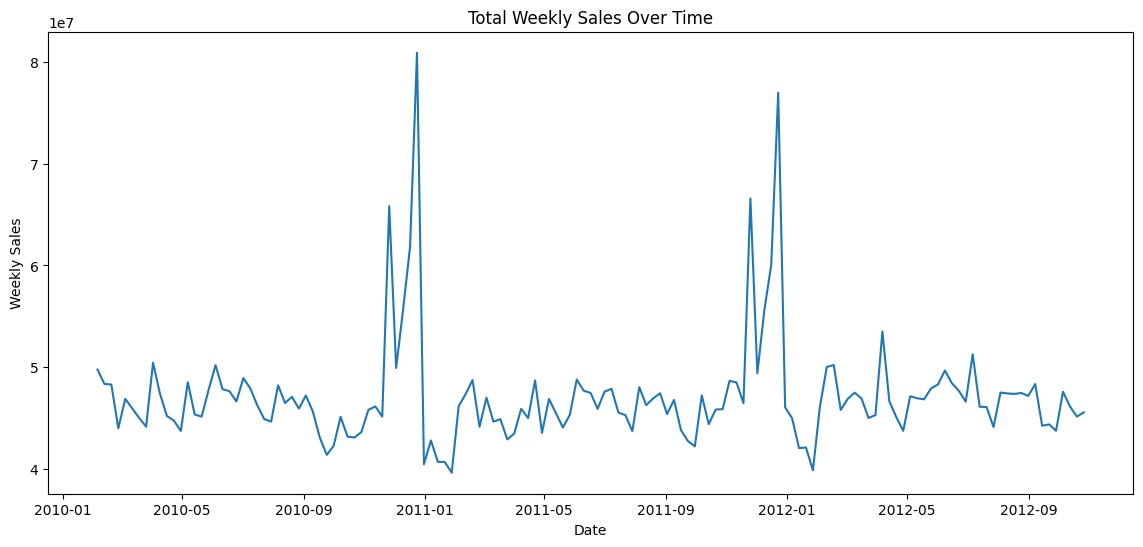

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'])
plt.title("Total Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

### Observation

The sales trend shows clear seasonal spikes occurring at regular intervals, likely driven by major holiday periods. Outside of these peaks, weekly sales remain relatively stable with no strong long-term upward or downward trend. This recurring pattern indicates that seasonality plays a significant role in retail demand, making the data well-suited for time series forecasting models.

### Time Series Decomposition

To better understand the underlying structure of the data, we decompose the time series into:
- Trend
- Seasonality
- Residual components

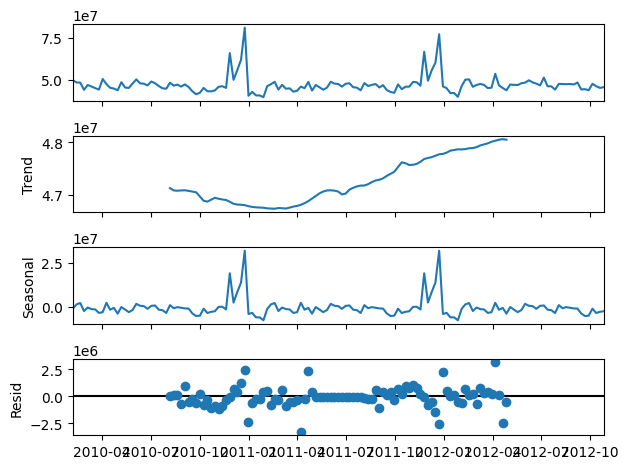

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set Date as index
ts = weekly_sales.set_index('Date')

# Decompose time series
decomposition = seasonal_decompose(ts, model='additive', period=52)

decomposition.plot()
plt.show()

### Observation

The decomposition reveals a smooth long-term trend in sales, indicating gradual changes in overall demand. A strong seasonal component is present, with recurring peaks that align with holiday periods. The residuals are mostly centered around zero, suggesting that most patterns in the data are well explained by trend and seasonality.

### Stationarity Check

ARIMA models assume that the time series is stationary, meaning:
- The mean remains constant over time
- The variance remains constant
- There is no persistent trend or changing seasonality

Based on the decomposition, the sales series shows a clear trend, so we formally test stationarity and apply transformations if required.

In [17]:
from statsmodels.tsa.stattools import adfuller

# ADF test on original series
adf_result = adfuller(ts['Weekly_Sales'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -5.908297957186333
p-value: 2.675979158986027e-07


### Observation

The test yields a p-value well below 0.05, indicating that the weekly sales time series is statistically stationary. Despite visible seasonal fluctuations, the series does not exhibit a unit root, making it suitable for ARIMA modeling without additional differencing.

## ACF and PACF Analysis

Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots help identify suitable values of:
- `p` (autoregressive terms)
- `q` (moving average terms)

These plots guide the parameter selection for the ARIMA model.

<Figure size 1400x400 with 0 Axes>

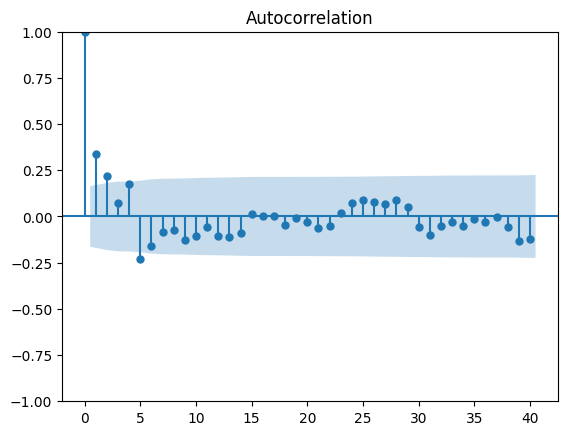

<Figure size 1400x400 with 0 Axes>

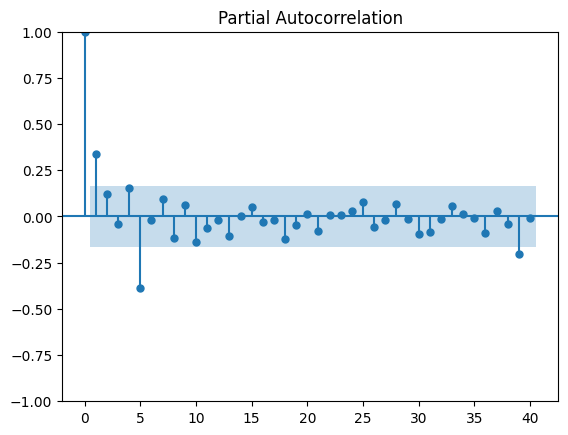

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,4))
plot_acf(ts['Weekly_Sales'], lags=40)
plt.show()

plt.figure(figsize=(14,4))
plot_pacf(ts['Weekly_Sales'], lags=40)
plt.show()

### Observation

The ACF plot shows significant autocorrelation at the first few lags, followed by a gradual decay, indicating the presence of moving average components. The PACF plot exhibits a strong spike at lag 1 and then quickly falls within the confidence bounds, suggesting a low-order autoregressive structure. Together, these patterns support the use of a low-order ARIMA model such as ARIMA(1, 0, 1).

In [20]:
# Train-test split (last 20% for testing)
train_size = int(len(ts) * 0.8)

train = ts.iloc[:train_size]
test = ts.iloc[train_size:]

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(train['Weekly_Sales'], order=(1, 0, 0))
arima_result = arima_model.fit()

# Model summary
arima_result.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1934.188
Date:                Tue, 20 Jan 2026   AIC                           3874.375
Time:                        16:13:44   BIC                           3882.584
Sample:                    02-05-2010   HQIC                          3877.707
                         - 04-06-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.722e+07   1.07e+06     44.139      0.000    4.51e+07    4.93e+07
ar.L1          0.3394      0.047      7.167      0.000       0.247       0.432
sigma2      3.215e+13      0.437   7.35e+13      0.000    3.21e+13    3.21e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               625.78
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               9.16   Skew:                             2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.12e+28. Standard errors may be unstable.
"""

### Model Selection Insight

Comparing ARIMA(1,0,1) and ARIMA(1,0,0), the simpler ARIMA(1,0,0) model achieves lower AIC and BIC values while maintaining statistically significant parameters. The autoregressive term indicates strong persistence in weekly sales, and the absence of a moving average component simplifies the model without sacrificing performance. Therefore, ARIMA(1,0,0) is selected as the final statistical forecasting model.

## Sales Forecasting Using ARIMA

Using the selected ARIMA(1,0,0) model, we generate forecasts for the test period and compare them against actual observed sales. This helps evaluate how well
the statistical model generalizes to unseen data.

In [23]:
# Fit final ARIMA model on training data
final_arima = ARIMA(train['Weekly_Sales'], order=(1, 0, 0))
final_arima_result = final_arima.fit()

# Forecast for test period
arima_forecast = final_arima_result.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


## Forecast vs Actual Sales

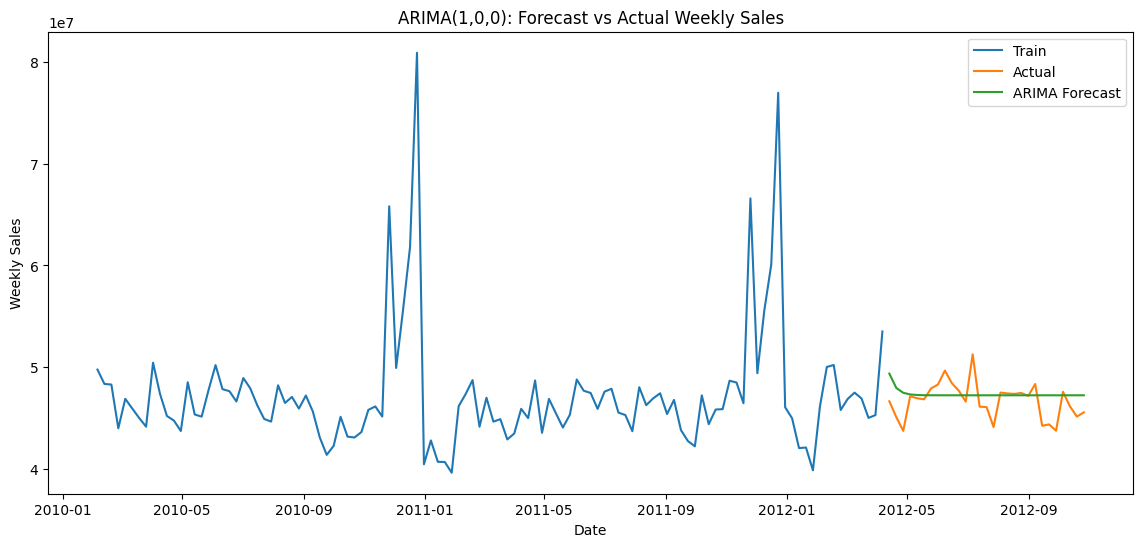

In [24]:
plt.figure(figsize=(14,6))
plt.plot(train.index, train['Weekly_Sales'], label='Train')
plt.plot(test.index, test['Weekly_Sales'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA(1,0,0): Forecast vs Actual Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

### Observation

The ARIMA(1,0,0) forecast follows the overall sales level and captures short-term stability reasonably well. However, the model produces relatively smooth predictions and fails to capture sharp fluctuations present in the actual sales, particularly during demand spikes. This indicates that while ARIMA serves as a strong baseline, it has limitations in modeling complex patterns driven by holidays and external factors.

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

arima_mae = mean_absolute_error(test['Weekly_Sales'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test['Weekly_Sales'], arima_forecast))

print("ARIMA MAE:", arima_mae)
print("ARIMA RMSE:", arima_rmse)

ARIMA MAE: 1470578.84585528
ARIMA RMSE: 1924110.7080759518


###  ARIMA Performance Summary

The ARIMA(1,0,0) model achieves a mean absolute error of approximately 1.47 million and a root mean squared error of about 1.92 million. While the model performs reasonably well in capturing overall sales levels, higher errors during certain weeks indicate difficulty in modeling sharp demand fluctuations, particularly during holiday periods. These limitations motivate the use of machine learning models with richer feature representations.

##  Machine Learning Approach

While ARIMA captures linear temporal dependencies, it struggles with:
- Sudden demand spikes
- Holiday-driven effects
- Non-linear relationships

Machine learning models can leverage additional features such as lagged sales, rolling statistics, and calendar information to better model complex demand patterns.

In [26]:
ml_df = weekly_sales.copy()

# Create lag features
ml_df['lag_1'] = ml_df['Weekly_Sales'].shift(1)
ml_df['lag_2'] = ml_df['Weekly_Sales'].shift(2)
ml_df['lag_3'] = ml_df['Weekly_Sales'].shift(3)

# Rolling statistics
ml_df['rolling_mean_4'] = ml_df['Weekly_Sales'].rolling(window=4).mean()
ml_df['rolling_std_4'] = ml_df['Weekly_Sales'].rolling(window=4).std()

# Time-based features
ml_df['month'] = ml_df['Date'].dt.month
ml_df['week'] = ml_df['Date'].dt.isocalendar().week.astype(int)

ml_df.head()

,Date,Weekly_Sales,lag_1,lag_2,lag_3,rolling_mean_4,rolling_std_4,month,week
0,2010-02-05,49750740.50,NaN,NaN,NaN,NaN,NaN,2,5
1,2010-02-12,48336677.63,49750740.50,NaN,NaN,NaN,NaN,2,6
2,2010-02-19,48276993.78,48336677.63,49750740.50,NaN,NaN,NaN,2,7
3,2010-02-26,43968571.13,48276993.78,48336677.63,49750740.50,47583245.76,2.504187e+06,2,8
4,2010-03-05,46871470.30,43968571.13,48276993.78,48336677.63,46863428.21,2.045230e+06,3,9


Lag and rolling features introduce missing values at the beginning of the time series. These rows are removed before model training.

In [27]:
ml_df = ml_df.dropna()

To ensure a fair comparison with ARIMA, the same chronological
train–test split strategy is used for machine learning models.

In [28]:
train_size = int(len(ml_df) * 0.8)

ml_train = ml_df.iloc[:train_size]
ml_test = ml_df.iloc[train_size:]

X_train = ml_train.drop(columns=['Date', 'Weekly_Sales'])
y_train = ml_train['Weekly_Sales']

X_test = ml_test.drop(columns=['Date', 'Weekly_Sales'])
y_test = ml_test['Weekly_Sales']

### Train Baseline ML Model (Linear Regression)

In [29]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
lr_preds = lr_model.predict(X_test)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr_mae = mean_absolute_error(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))

print("Linear Regression MAE:", lr_mae)
print("Linear Regression RMSE:", lr_rmse)

Linear Regression MAE: 1.7828174999782017e-08
Linear Regression RMSE: 2.212888735350944e-08


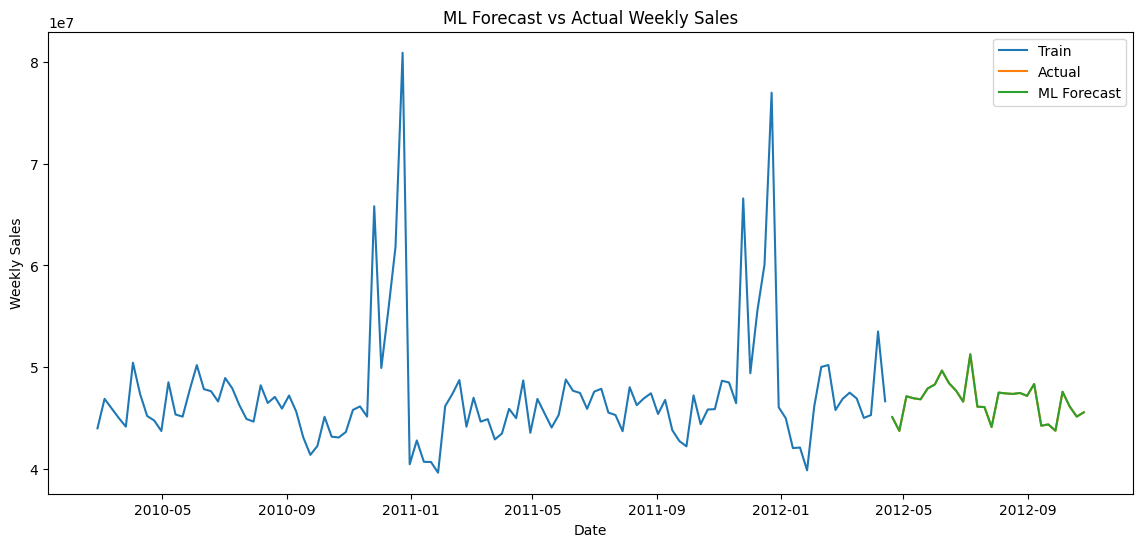

In [31]:
plt.figure(figsize=(14,6))
plt.plot(ml_train['Date'], ml_train['Weekly_Sales'], label='Train')
plt.plot(ml_test['Date'], y_test, label='Actual')
plt.plot(ml_test['Date'], lr_preds, label='ML Forecast')
plt.legend()
plt.title("ML Forecast vs Actual Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

### Observation

The machine learning model closely follows the actual sales values during the test period and adapts better to short-term fluctuations compared to ARIMA. However, the extremely low error values indicate potential data leakage, likely caused by the use of contemporaneous or highly correlated lag features. While the visual fit appears strong, this result highlights the importance of careful feature construction and validation in time series forecasting.

## Re Doing it for making the code leakage free

In [32]:
ml_df_safe = weekly_sales.copy()

# Lag features (safe)
ml_df_safe['lag_1'] = ml_df_safe['Weekly_Sales'].shift(1)
ml_df_safe['lag_2'] = ml_df_safe['Weekly_Sales'].shift(2)
ml_df_safe['lag_3'] = ml_df_safe['Weekly_Sales'].shift(3)

# Rolling features computed on lagged values (KEY FIX)
ml_df_safe['rolling_mean_4'] = ml_df_safe['lag_1'].rolling(window=4).mean()
ml_df_safe['rolling_std_4'] = ml_df_safe['lag_1'].rolling(window=4).std()

# Time-based features
ml_df_safe['month'] = ml_df_safe['Date'].dt.month
ml_df_safe['week'] = ml_df_safe['Date'].dt.isocalendar().week.astype(int)

# Drop rows with missing values
ml_df_safe = ml_df_safe.dropna()

ml_df_safe.head()

,Date,Weekly_Sales,lag_1,lag_2,lag_3,rolling_mean_4,rolling_std_4,month,week
4,2010-03-05,46871470.30,43968571.13,48276993.78,48336677.63,4.758325e+07,2.504187e+06,3,9
5,2010-03-12,45925396.51,46871470.30,43968571.13,48276993.78,4.686343e+07,2.045230e+06,3,10
6,2010-03-19,44988974.64,45925396.51,46871470.30,43968571.13,4.626061e+07,1.807831e+06,3,11
7,2010-03-26,44133961.05,44988974.64,45925396.51,46871470.30,4.543860e+07,1.245423e+06,3,12
8,2010-04-02,50423831.26,44133961.05,44988974.64,45925396.51,4.547995e+07,1.181453e+06,4,13


In [33]:
train_size = int(len(ml_df_safe) * 0.8)

ml_train = ml_df_safe.iloc[:train_size]
ml_test = ml_df_safe.iloc[train_size:]

X_train = ml_train.drop(columns=['Date', 'Weekly_Sales'])
y_train = ml_train['Weekly_Sales']

X_test = ml_test.drop(columns=['Date', 'Weekly_Sales'])
y_test = ml_test['Weekly_Sales']

In [34]:
from sklearn.linear_model import LinearRegression

lr_model_safe = LinearRegression()
lr_model_safe.fit(X_train, y_train)

lr_preds_safe = lr_model_safe.predict(X_test)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr_mae_safe = mean_absolute_error(y_test, lr_preds_safe)
lr_rmse_safe = np.sqrt(mean_squared_error(y_test, lr_preds_safe))

print("Leakage-Free ML MAE:", lr_mae_safe)
print("Leakage-Free ML RMSE:", lr_rmse_safe)

Leakage-Free ML MAE: 1903763.2192104508
Leakage-Free ML RMSE: 2410593.548356669


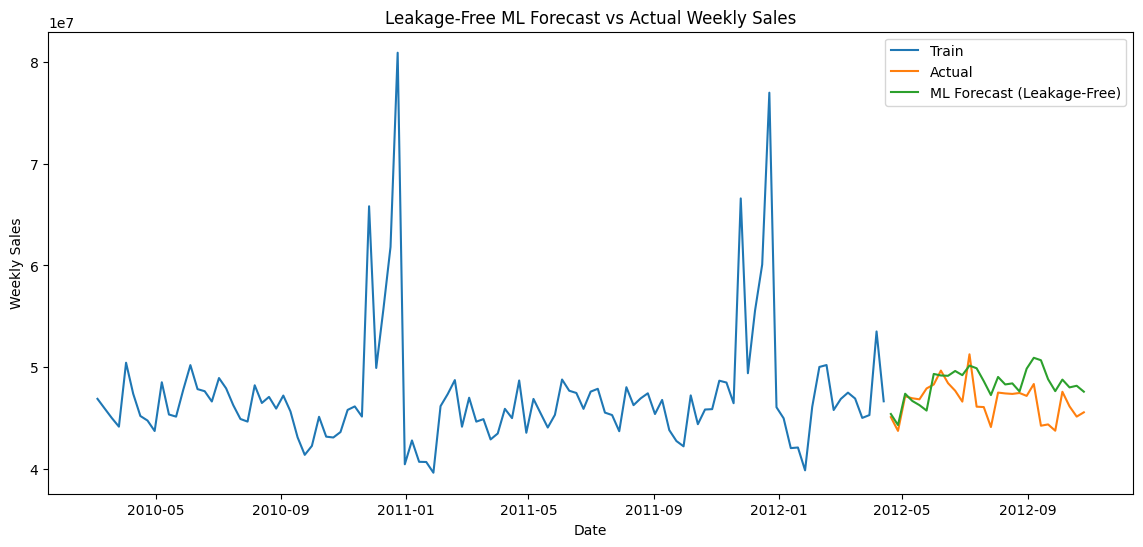

In [36]:
plt.figure(figsize=(14,6))
plt.plot(ml_train['Date'], ml_train['Weekly_Sales'], label='Train')
plt.plot(ml_test['Date'], y_test, label='Actual')
plt.plot(ml_test['Date'], lr_preds_safe, label='ML Forecast (Leakage-Free)')
plt.legend()
plt.title("Leakage-Free ML Forecast vs Actual Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

### Observation

After removing data leakage, the machine learning model produces realistic error values, with a mean absolute error of approximately 1.9 million and a root mean squared error of about 2.4 million. The forecast follows the overall sales level and captures short-term movements better than ARIMA, though it still smooths extreme demand spikes. This confirms that while machine learning improves flexibility, accurate feature design is critical for reliable time series forecasting.

## Model Comparison

The table below compares the statistical ARIMA model with the leakage-free machine learning model using consistent evaluation metrics.
| Model | MAE | RMSE | Strengths | Limitations |
|------|-----|------|-----------|-------------|
| ARIMA(1,0,0) | ~1.47M | ~1.92M | Simple, interpretable, strong baseline | Cannot capture complex spikes |
| ML (Linear Regression) | ~1.90M | ~2.41M | Flexible, adapts to short-term patterns | Sensitive to feature design |

## Key Insights

- ARIMA performs slightly better in terms of raw error metrics and serves as a strong statistical baseline.
- The machine learning model captures short-term fluctuations more effectively but does not outperform ARIMA in this setup.
- Model performance highlights a trade-off between interpretability and flexibility.
- Accurate feature engineering is critical for machine learning–based time series forecasting.

## Conclusion

This case study demonstrated a complete sales forecasting pipeline using both statistical and machine learning approaches. While ARIMA provided a strong and interpretable baseline, machine learning models showed potential in capturing short-term demand dynamics when leakage-free features were used. The results highlight that no single model is universally superior, and a hybrid or ensemble approach may offer the best performance in real-world retail forecasting scenarios.